In [1]:
import jax
from jax import numpy as jnp
from jax import random
import flax
import optax
import distrax
import tensorflow as tf
import tensorflow_datasets as tfds
from clu import preprocess_spec
import matplotlib.pyplot as plt

from NeurReps import preprocess_utils

In [2]:
BATCH_SIZE = 256

In [20]:
pp_train = 'value_range(-1, 1)|random_rotate(0, 90)|keep(["image"])'
preprocess_fn = preprocess_spec.parse(
          spec=pp_train, available_ops=preprocess_utils.all_ops())

def preprocess_with_rng(example_index, features):
    example_index = tf.cast(example_index, tf.int32)
    features["rng"] = tf.random.experimental.stateless_fold_in(
        tf.cast(rng, tf.int64), example_index)
    processed = preprocess_fn(features)
    # del processed["rng"]
    return processed

In [21]:
rng = random.PRNGKey(42)
rng, shuffle_rng = random.split(rng, num=2)
ds = tfds.load('MNIST', split='train')
ds = ds.shuffle(10_000, seed=shuffle_rng[0])
# NOTE: ordering of PP and repeat is important! 
# PP first -> same seed each time we see same example.
# PP last -> diff seed each time we see same example. Effectively more data.
ds = ds.enumerate().map(preprocess_with_rng, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.repeat()
ds = ds.batch(batch_size=BATCH_SIZE)
ds = ds.prefetch(tf.data.AUTOTUNE)
ds = ds.as_numpy_iterator()

2022-09-18 09:15:45.395998: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


-0.698867


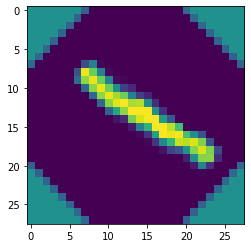

-0.85255843


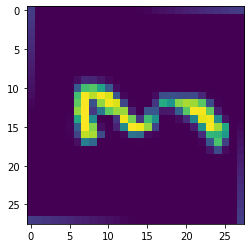

-0.68097377


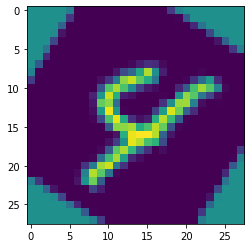

In [22]:
for _ in range(3):
    batch = next(ds)
    print(batch['image'][0].mean())
    plt.imshow(batch['image'][0])
    plt.show()

-0.8680672


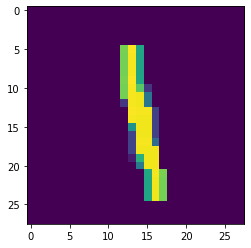

-0.8656763


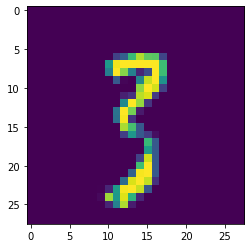

-0.8387855


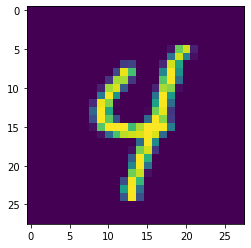

In [19]:
for _ in range(3):
    batch = next(ds)
    print(batch['image'][0].mean())
    plt.imshow(batch['image'][0])
    plt.show()